In [18]:
# Temel kullanılan kütüphaneler

import datasets
import transformers
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from tqdm import tqdm
from pathlib import Path


In [ ]:
_ = load_dotenv()

TOKEN = os.environ['TOKEN_ID']


In [28]:
from huggingface_hub import notebook_login

notebook_login()

In [44]:
# Kaggle input-tree yerine path kullanarak verinin yolunu alma

path = Path('/kaggle/input/turkish-to-english-translation-dataset')
files = [str(x) for x in path.glob('**/*.txt')]
files

['/kaggle/input/turkish-to-english-translation-dataset/TR2EN.txt']

In [45]:
# Dosya formatı *.txt olduğundan  read_table() ile pandasframe'e dönüştür, columnsları rename et.

tqdm.pandas()
data = pd.concat(chunk for chunk in tqdm(pd.read_table(files[0], chunksize=1000), desc='Loading data'))
data.columns = ["english","turkish"]
data.head(10)

Loading data: 474it [00:01, 408.87it/s]


,english,turkish
0,Hi.,Selam.
1,Run!,Kaç!
2,Run!,Koş!
3,Run.,Kaç!
4,Run.,Koş!
5,Who?,Kim?
6,Fire!,Ateş!
7,Fire!,Yangın!
8,Help!,Yardım et!
9,Jump.,Defol.


In [46]:
# Türkçe ve İngilizce satırlarının eşit olma kontrolü

data.columns = ["english","turkish"]
print(data["turkish"].count() == data["english"].count())

True


In [47]:
# Türkçe ve İngilizce satırlarda eksik değer kontrolü

print(data.loc[data["english"].isna() | data["turkish"].isna()])

Empty DataFrame
Columns: [english, turkish]
Index: []


In [48]:
# Türkçedeki bazı sesli harfleri ve ğ harfini ingilizce ile uyumlu tokenize etmek için dönüştür.

def replace_character(elem):
    elem = elem.replace("ş","s")
    elem = elem.replace("ö","o")
    elem = elem.replace("ü","u")
    elem = elem.replace("ç","c")
    elem = elem.replace("ğ","g")
    elem = elem.replace("ı","i")
    return elem

In [49]:
data = data.progress_map(replace_character)

100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


In [50]:
data

,english,turkish
0,Hi.,Selam.
1,Run!,Kac!
2,Run!,Kos!
3,Run.,Kac!
4,Run.,Kos!
...,...,...
473029,A carbon footprint is the amount of carbon dio...,Bir karbon ayakizi bizim faaliyetlerimizin bir...
473030,"At a moment when our economy is growing, our b...",Ekonomimizin buyudugu bir anda bizim isletmele...
473031,Using high heat settings while ironing synthet...,Sentetik kumaslari utulerken yuksek isi ayarla...
473032,"If you want to sound like a native speaker, yo...","Eger bir yerli gibi konusmak istiyorsan, banco..."


In [51]:
# Sentence piece tekniği kullanarak preprocess etme

data['english'].to_csv('english.txt', index=False, header=False)
data['turkish'].to_csv('turkish.txt', index=False, header=False)

import sentencepiece as spm

# Kaynak dil (İngilizce) için SentencePiece modelini eğitme
spm.SentencePieceTrainer.train(
    input='english.txt',  # İngilizce cümlelerin bulunduğu dosya
    model_prefix='source_spm',
    vocab_size=19000,
    character_coverage=0.9995
)

# Hedef dil (Türkçe) için SentencePiece modelini eğitme
spm.SentencePieceTrainer.train(
    input='turkish.txt',  # Türkçe cümlelerin bulunduğu dosya
    model_prefix='target_spm',
    vocab_size=19000,
    character_coverage=0.9995
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: english.txt
  input_format: 
  model_prefix: source_spm
  model_type: UNIGRAM
  vocab_size: 19000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  dif

In [59]:
# SentencePiece modellerini yükleyin

source_sp = spm.SentencePieceProcessor(model_file='source_spm.model')
target_sp = spm.SentencePieceProcessor(model_file='target_spm.model')

In [60]:
# Pandas dataframe to hugging-face dataset

raw_data = datasets.Dataset.from_pandas(data)

In [61]:
raw_data

Dataset({
    features: ['english', 'turkish'],
    num_rows: 473034
})

In [62]:
# Veri setini tekrar karıştır

raw_data = raw_data.shuffle(50)

In [63]:
# 10. indisteki örneği al

raw_data[10]

{'english': "Tom doesn't always play by the rules.",
 'turkish': 'Tom her zaman kurallariyla oynamaz.'}

In [64]:
# kontrol etmek için türkçe örnek al

raw_data["turkish"][0]

"Tom sadece Mary'yi korumaya calisiyordu."

In [65]:
# sentenpiece ile sözcükleri unigram şekilde tokenize et

def sentencepiece_data(example):
    source_tokens = source_sp.encode(example['english'], out_type=str)
    target_tokens = target_sp.encode(example['turkish'], out_type=str)
    return {
        'source_tokens': ' '.join(source_tokens),
        'target_tokens': ' '.join(target_tokens)
    }

In [66]:
# batched false her defasında tek tek işle

tokenized_dataset = raw_data.map(sentencepiece_data, batched=False)

Map:   0%|          | 0/473034 [00:00<?, ? examples/s]

In [67]:
print(tokenized_dataset[0])

{'english': 'Tom was just trying to protect Mary.', 'turkish': "Tom sadece Mary'yi korumaya calisiyordu.", 'source_tokens': '▁Tom ▁was ▁just ▁trying ▁to ▁protect ▁Mary .', 'target_tokens': "▁Tom ▁sadece ▁Mary ' yi ▁korumaya ▁calisiyordu ."}


In [103]:
from transformers import TFT5ForConditionalGeneration, T5Tokenizer

model = TFT5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [104]:
# Modele başlangıç ve bitiş tokenlarını belirt ve veri seti üzerinde map ederek vocub oluştur

def preprocess_function(elems):
    try:
        # Tokenizer'ı kullanarak girdi ve hedef verileri tokenize etme
        inputs = tokenizer(elems['source_tokens'], max_length=128, truncation=True, padding='max_length')
        targets = tokenizer(elems['target_tokens'], max_length=128, truncation=True, padding='max_length')
        
        # Girdi ve hedef verileri döndürme
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'labels': targets['input_ids']
        }
    except TypeError as e:
        raise ValueError("Tokenizer does not support the given parameters.") from e


In [105]:
final_tokenize_dataset = tokenized_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/473034 [00:00<?, ? examples/s]

In [107]:
print(tokenizer.decode(final_tokenize_dataset[100]["input_ids"]))
print("*"*250)
print(tokenizer.decode(final_tokenize_dataset[100]["labels"]))


I've discovered Tom's secret formula.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
**********************************************************************************************************************************************************************************************************************************************************
Tom'un gizli formu l unu kesfetti m.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [108]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(final_tokenize_dataset, test_size=0.1, random_state=42)


In [109]:
from transformers import DataCollatorForSeq2Seq # train ve test setleri hazırlanırken datasetin daha kontrollü olması için collator kullan

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, return_tensors="tf")

In [110]:
model.build()

In [111]:
model.summary()

Model: "tft5_for_conditional_generation_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
train_data = datasets.Dataset.from_dict(train_data) # train-test splitte dict çevrilmiş sözlüğü 


In [113]:
val_data = datasets.Dataset.from_dict(test_data)

In [114]:
tf_train_set = model.prepare_tf_dataset(  # Modelin train-test setlerini hazırla 
    train_data,
    shuffle=True,
    batch_size= 32,
    collate_fn=data_collator
)

tf_validation_set = model.prepare_tf_dataset(
    val_data,
    shuffle=False,
    batch_size=32,
    collate_fn=data_collator
)

In [115]:
print(tf_train_set.element_spec)
print(tf_validation_set.element_spec)

({'input_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None)}, TensorSpec(shape=(32, 128), dtype=tf.int64, name=None))
({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 128), dtype=tf.int64, name=None))


In [ ]:
from transformers import AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=8e-5, weight_decay_rate=0.01)

In [117]:
model.compile(optimizer=optimizer, metrics=["accuracy"])

In [119]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=2)

Epoch 1/2
13304/13304 [==============================] - 5375s 404ms/step - loss: 0.1091 - accuracy: 0.9735 - val_loss: 0.0832 - val_accuracy: 0.9797
Epoch 2/2
13304/13304 [==============================] - 5374s 404ms/step - loss: 0.0982 - accuracy: 0.9758 - val_loss: 0.0767 - val_accuracy: 0.9811


In [173]:
model.push_to_hub('Bilgekul/t5-small-turkish-english-translator')
tokenizer.push_to_hub('Bilgekul/t5-base-turkish-english-translator')

CommitInfo(commit_url='https://huggingface.co/Bilgekul/t5-base-turkish-english-translator/commit/7391cd15ce194854a3a4545d48c6eaeea97b1614', commit_message='Upload tokenizer', commit_description='', oid='7391cd15ce194854a3a4545d48c6eaeea97b1614', pr_url=None, pr_revision=None, pr_num=None)

In [121]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and Validation Accuracy')

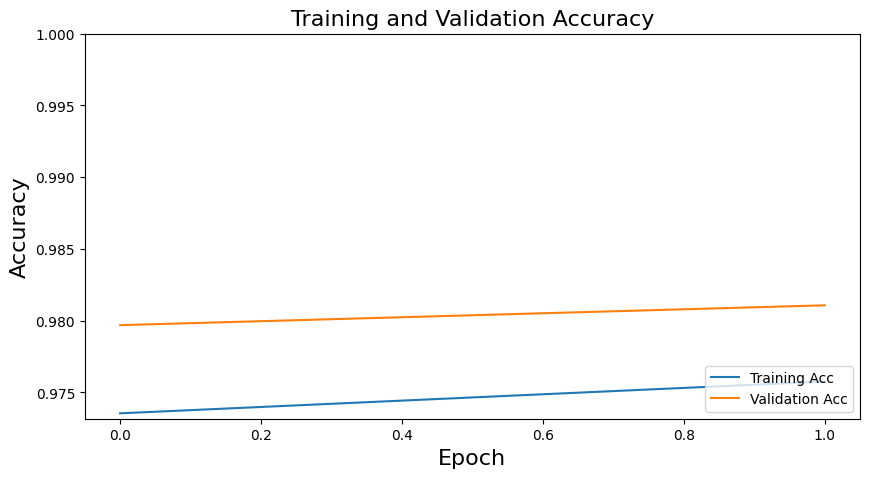

In [164]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history["accuracy"], label="Training Acc")
plt.plot(model.history.history["val_accuracy"], label="Validation Acc")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy", fontsize=16)

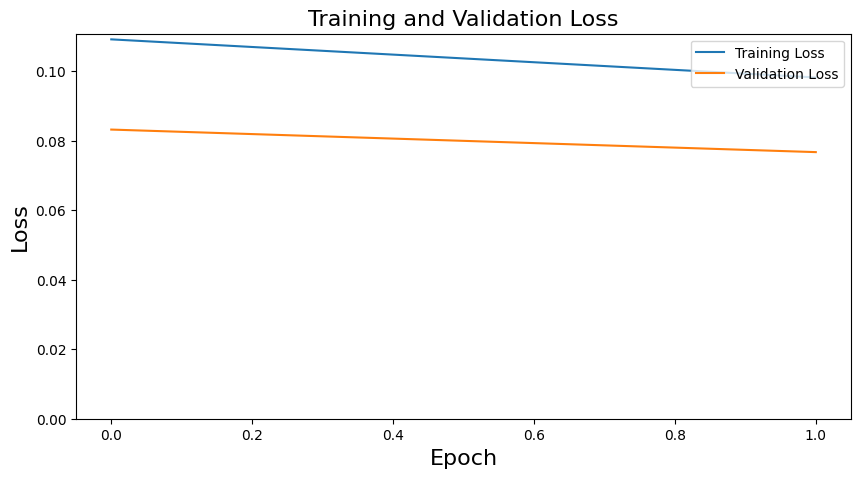

In [165]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history["loss"], label="Training Loss")
plt.plot(model.history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize=16)
plt.show()